In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the dataset
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Resize and batch
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128)) / 255.0
    return image, label

ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.EUKVLO_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


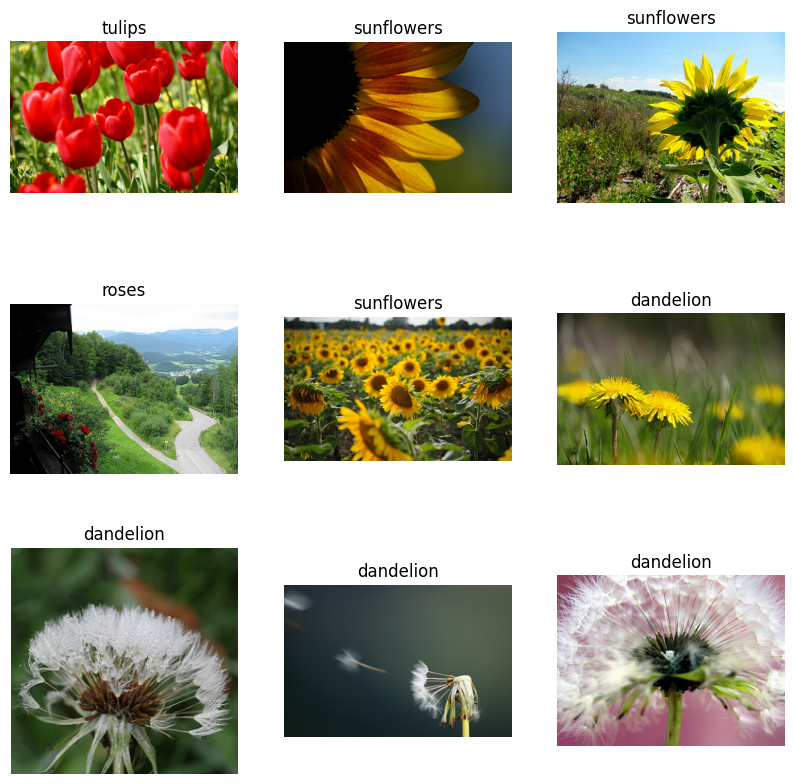

In [7]:
dataset, info = tfds.load('tf_flowers', split='train', with_info=True, as_supervised=True)

# Class names
class_names = info.features['label'].names

# Take a few samples to plot
plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(dataset.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_names[label.numpy()])
    plt.axis('off')

plt.show()

In [8]:
ds, ds_info = tfds.load('tf_flowers', split='train', with_info=True)

# Take one example to check image size
for example in ds.take(1):
    image = example['image']
    print("Image shape:", image.shape)
    print("Image height:", image.shape[0])
    print("Image width:", image.shape[1])
    print("Number of channels:", image.shape[2])

Image shape: (333, 500, 3)
Image height: 333
Image width: 500
Number of channels: 3


dandelion: 898 images
daisy: 633 images
tulips: 799 images
sunflowers: 699 images
roses: 641 images


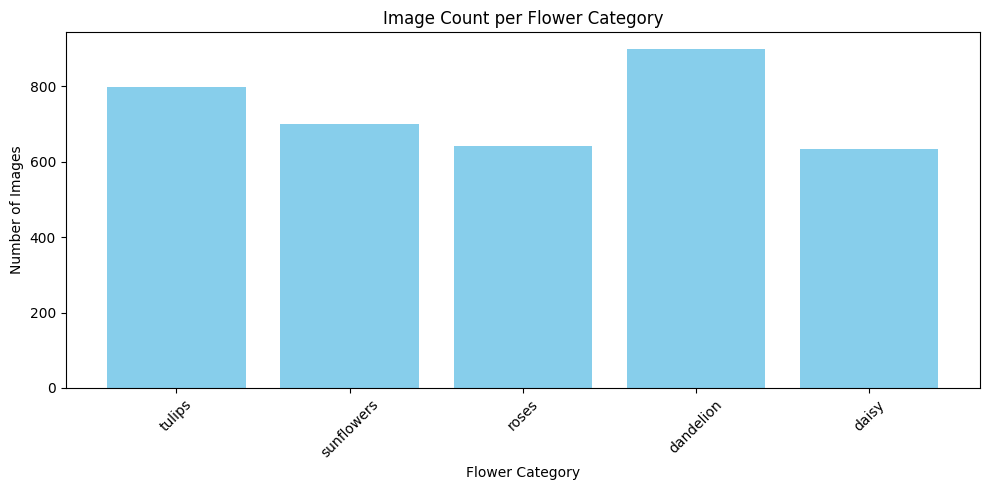

In [13]:
import collections


ds, ds_info = tfds.load('tf_flowers', split='train', with_info=True)
label_names = ds_info.features['label'].names  # Flower category names

# Function to extract labels
def extract_label(example):
    return example['label']

# Extract labels and count
labels = ds.map(extract_label)
label_counts = collections.Counter()

for label in labels:
    label_counts[int(label.numpy())] += 1

# Print the counts with label names
for idx, count in sorted(label_counts.items()):
    print(f"{label_names[idx]}: {count} images")

# Optional: Plot a bar chart
plt.figure(figsize=(10, 5))
plt.bar([label_names[idx] for idx in label_counts.keys()],
        label_counts.values(), color='skyblue')
plt.title('Image Count per Flower Category')
plt.xlabel('Flower Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

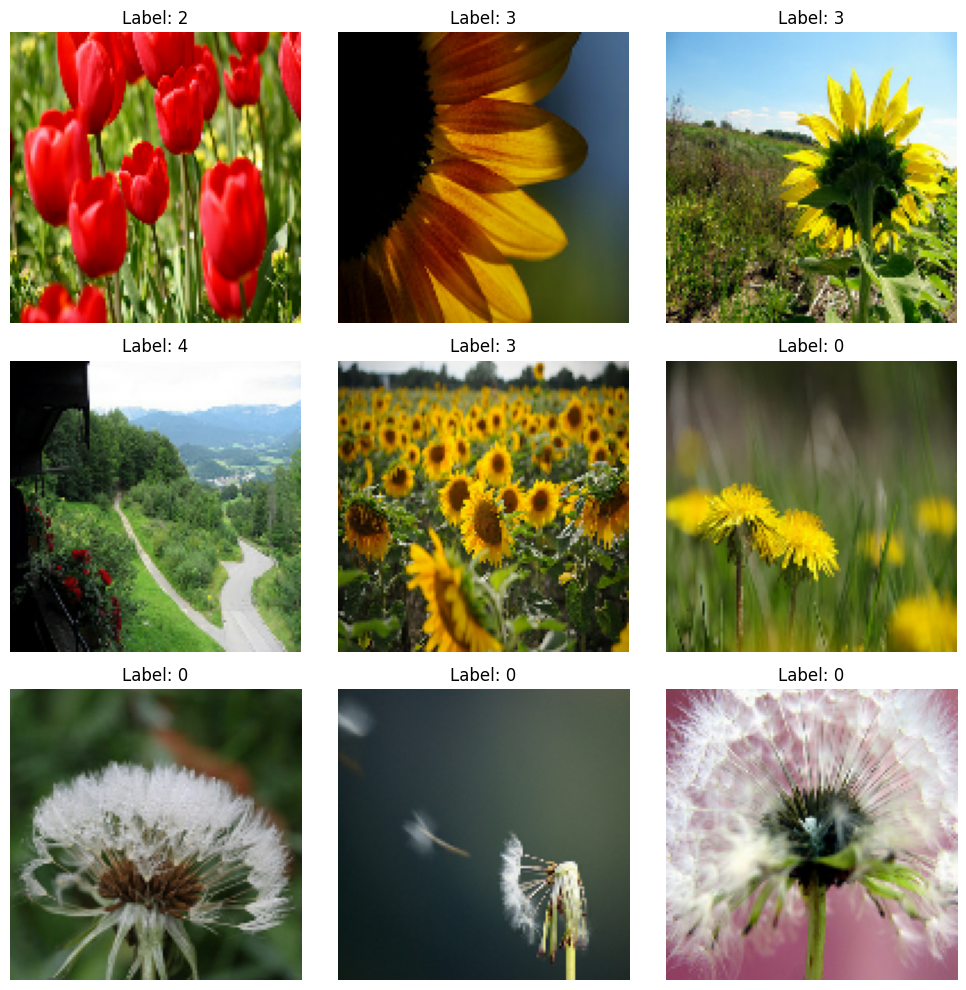

In [10]:

# Resize function
def resize_image(example):
    image = example['image']
    label = example['label']
    image = tf.image.resize(image, [128, 128])  # Resize to 128x128
    image = tf.cast(image, tf.uint8)  # Convert to uint8 for visualization
    return image, label

# Apply resizing to the dataset
resized_ds = ds.map(resize_image)

# Plot some resized images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(resized_ds.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 549ms/step - accuracy: 0.4618 - loss: 1.4661 - val_accuracy: 0.7929 - val_loss: 0.5966
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 512ms/step - accuracy: 0.7356 - loss: 0.7014 - val_accuracy: 0.8420 - val_loss: 0.4730
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 52s 514ms/step - accuracy: 0.8027 - loss: 0.5752 - val_accuracy: 0.8215 - val_loss: 0.4689
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 514ms/step - accuracy: 0.7978 - loss: 0.5534 - val_accuracy: 0.8665 - val_loss: 0.3917
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 486ms/step - accuracy: 0.8261 - loss: 0.4833 - val_accuracy: 0.8665 - val_loss: 0.3707


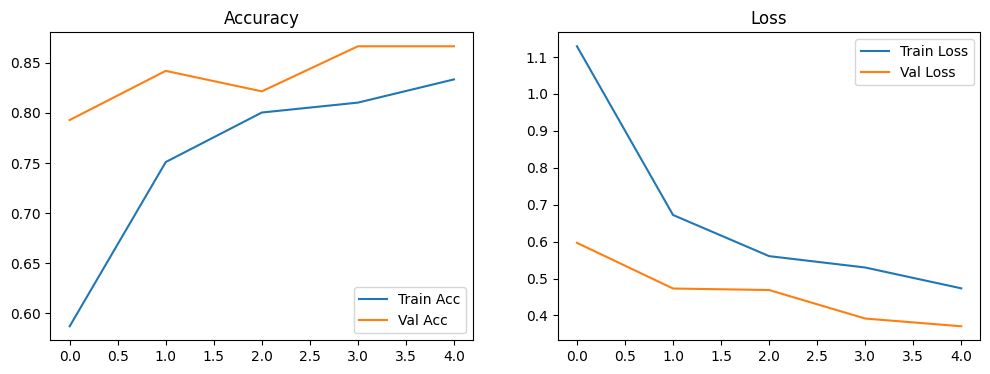

In [23]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 5
NUM_CLASSES = 5  # tf_flowers has 5 classes

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Preprocess function
def preprocess(example):
    image = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    label = example['label']
    return image, label

# Load dataset splits
ds_train = tfds.load('tf_flowers', split='train[:80%]', as_supervised=False)
ds_val = tfds.load('tf_flowers', split='train[80%:]', as_supervised=False)

# Prepare training dataset with augmentation
train = ds_train.map(preprocess)
train = train.map(lambda x, y: (data_augmentation(x), y))
train = train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare validation dataset without augmentation
val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load pretrained MobileNetV2 without top layer and freeze it
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Build the model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # regularization
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train,
                    validation_data=val,
                    epochs=EPOCHS,
                    callbacks=[early_stop])

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


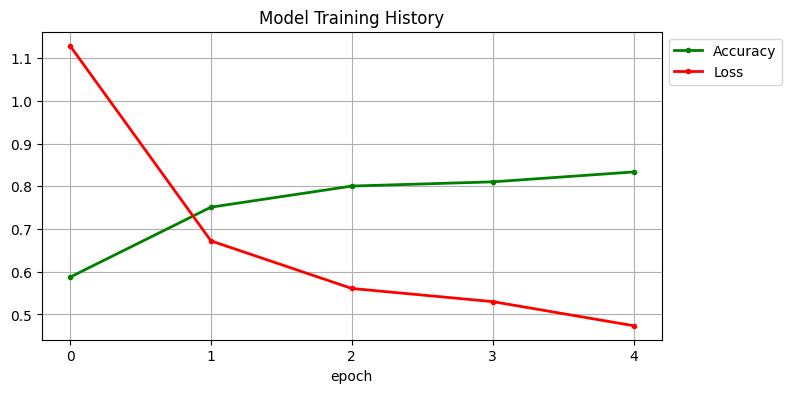

In [25]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(EPOCHS)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [24]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Step 2: Load class names from dataset metadata
builder = tfds.builder('tf_flowers')
builder.download_and_prepare()
class_names = builder.info.features['label'].names  # e.g., ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

# Step 3: Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

   dandelion       0.92      0.88      0.90       159
       da

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


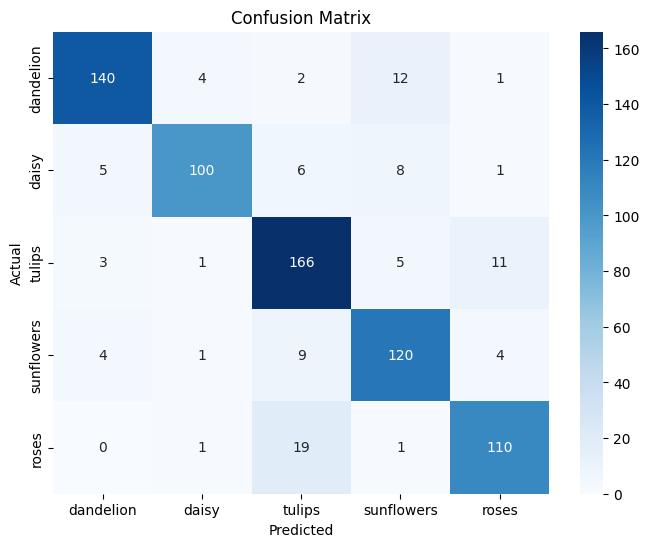

              precision    recall  f1-score   support

   dandelion       0.92      0.88      0.90       159
       daisy       0.93      0.83      0.88       120
      tulips       0.82      0.89      0.86       186
  sunflowers       0.82      0.87      0.85       138
       roses       0.87      0.84      0.85       131

    accuracy                           0.87       734
   macro avg       0.87      0.86      0.87       734
weighted avg       0.87      0.87      0.87       734



In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Get true labels and predictions from the validation set
y_true = []
y_pred = []

for images, labels in val:  # 'val' is your validation dataset
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot confusion matrix
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


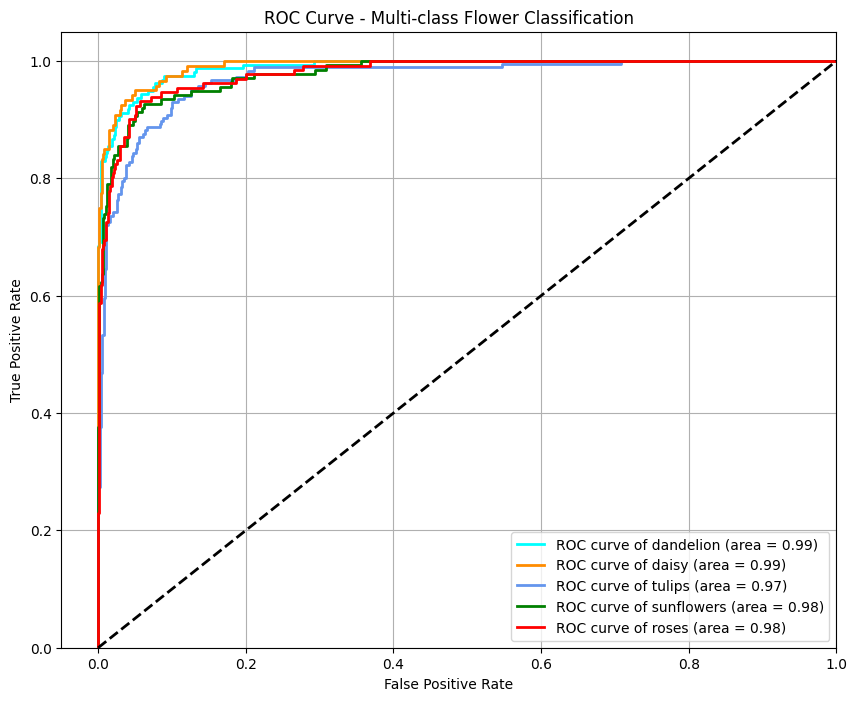

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Step 1: Get true labels and predicted probabilities
y_true = []
y_score = []

for images, labels in val:
    preds = model.predict(images)  # shape: (batch_size, 5)
    y_true.extend(labels.numpy())
    y_score.extend(preds)

y_true = np.array(y_true)
y_score = np.array(y_score)

# Step 2: Binarize the true labels (needed for multi-class ROC)
n_classes = 5
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])

# Step 3: Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class Flower Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


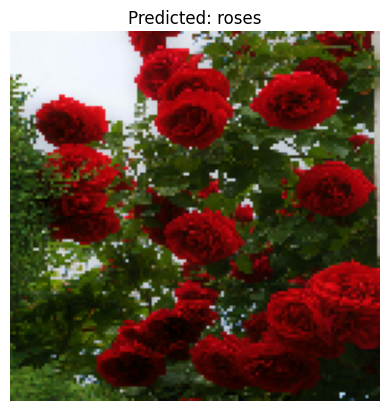

78.28594 %


In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Your class names
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

# Define image size (same as training)
IMG_SIZE = 128

# Function to load and preprocess custom image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# 🔽 Replace this with your image path (upload if in Colab)
image_path = "/content/test2.jpg"  # Example path

# Load and predict
image = load_and_preprocess_image(image_path)
prediction = model.predict(image)
predicted_class = np.argmax(prediction)
confidence_score = np.max(prediction, axis=1)[0]

# Display the image and prediction
if confidence_score*100 > 50:
  plt.imshow(image[0])
  plt.axis('off')
  plt.title(f"Predicted: {class_names[predicted_class]}")
  plt.show()
else:
  print("Flower Image Not Identified")

print(confidence_score*100,"%")

In [46]:
model.save('model.h5')

In [47]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')